## FIGURE 1

C:\Users\ak7550\AppData\Local\Temp\ipykernel_37616\618025353.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  modified_colors = plt.cm.get_cmap("terrain").reversed()(np.linspace(0, 1, 256))[30:]  # Assuming 256 colors


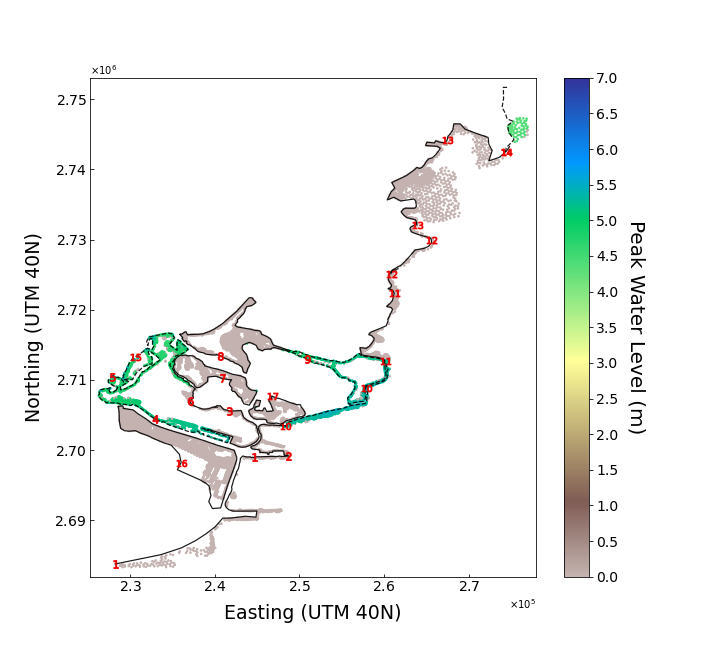

In [2]:
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
plt.close()
%matplotlib widget
from pyproj import Transformer

####### Helper Functions ##############


def get_coord(x,y, m):
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:32640")
    if m == "east":
        return transformer.transform(x,y)[0]
    else:
        return transformer.transform(x,y)[1]

def get_boundaries():
    path = "Precinct_Weirs_2040_fxw.pliz"
    df = pd.read_fwf(path, header=None, names=['p', 'y', '0', '1', '2'])
    l = iter(np.repeat(df[df['p'].str.contains('P')].p.index.to_numpy(), 2)[1:])
    l = list(zip(l, l))
    l.append((l[-1][-1], df.shape[0]))
    df_list=[df.iloc[range(*i),:] for i in l]
    df_list = [i.loc[pd.to_numeric(i['p'], errors='coerce').notnull(), ["p","y"]] for i in df_list]
    cord_lists = []
    for df in df_list:
        coords = pd.DataFrame(columns=["x", "y"])
        coords['x'] = df.apply(lambda x: get_coord(x.y, x.p, "east"), axis=1)
        coords['y'] = df.apply(lambda x: get_coord(x.y, x.p, "nort"), axis=1)
        cord_lists.append(coords)
    cord_lists[15].loc[len(cord_lists[15].index)] = [236480, 2702130]
    cord_lists[15].loc[len(cord_lists[15].index)] = [242000, 2696470]
    cord_lists[15].loc[len(cord_lists[15].index)] = [241130, 2693550]
    return cord_lists

####### Helper Functions END ##############



scenario = "10101010101010101"
scenario = "11100111001110011"

mask = np.load("ad_full_grid_1024.npy", allow_pickle=True).item()
idx = np.array(list(mask.values()))
coords = np.array(list(mask.keys()))
input_matrix = np.load("./data/Holdout/" + scenario + ".output.npy", allow_pickle=True)

df = pd.DataFrame(data=coords, columns=['x', 'y'])


rows, cols = idx[:, 1], idx[:, 0]
df.insert(2, "z", input_matrix[rows, cols])

plt.rcParams["figure.figsize"] = (10, 9)
plt.rcParams["figure.dpi"] = 72



modified_colors = plt.cm.get_cmap("terrain").reversed()(np.linspace(0, 1, 256))[30:]  # Assuming 256 colors

# Create a new colormap from the modified color list
new_cmap = mcolors.LinearSegmentedColormap.from_list("modified_terrain", modified_colors)


ax = df.plot.scatter(x='x', y='y',c='z', s=10, cmap=new_cmap, marker='.', vmin=0, vmax=7)


ax.margins(x=0.02)
ax.margins(y=0.02)
ax.xaxis.set_tick_params(direction="in")
ax.yaxis.set_tick_params(direction="in")


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


formatter = mticker.ScalarFormatter(useMathText=True)
ax.xaxis.set_major_formatter(formatter)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

formatter = mticker.ScalarFormatter(useMathText=True)
ax.yaxis.set_major_formatter(formatter)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax.set_xlabel("Easting (UTM 40N)", fontsize=19, labelpad=10)
ax.set_ylabel("Northing (UTM 40N)", fontsize=19, labelpad=10)



preccincts = get_boundaries()


from matplotlib.lines import Line2D
markerindex = np.random.randint(0, len(Line2D.markers), 17)

mkevery = [0,-15]
mkeverysmall= [0,-10]
mkeverysmingle = [10]
mkbegin = [0]
mkend = [-10]
mkmiddle = [35]
mkmiddle2 = [30]
mkcstm = [13]
mkcstm2 = [25]

preccincts[13] = preccincts[13][:15]

for i in range(len(scenario)):
    if i == 15:
        preccincts[i].drop(preccincts[i].tail(3).index,inplace=True)
    mrkevery = int(preccincts[i].x.shape[0]/1)
    if i == 0 or i == 9 or i == 10 or i == 12 or i == 13:
        mkr = mkevery
    elif i == 2 or i ==5:
        mkr = mkend
    elif i == 3:
        mkr = mkmiddle
    elif  i == 14:
        mkr = mkmiddle2
    elif  i == 15:
        mkr = mkcstm
    elif i ==7:
        mkr = mkcstm2
    elif  i == 11:
        mkr = mkeverysmall
    elif i == 16 or i ==1:
        mkr = mkbegin
    else:
        mkr = mkeverysmingle
    mkrsize = 8 if i < 9 else 11
    if scenario[i] == "1":
        ax.plot(preccincts[i].x, preccincts[i].y, linestyle="-", color='black', marker="$%d$"%(i+1), markevery=mkr, markersize=mkrsize, mec='red', linewidth = 1.2, alpha=0.9)
    else:
        ax.plot(preccincts[i].x, preccincts[i].y,linestyle="dashed", color='black', marker="$%d$"%(i+1), markevery=mkr, markersize=mkrsize, mec='red', linewidth = 1.2, alpha=0.9)

f = plt.gcf()
cax = f.get_axes()[1]
cax.yaxis.set_ticks(np.arange(0,7.1,0.5))
for label in cax.get_yticklabels() :
    label.set_fontsize(14)

cax.set_ylabel("Peak Water Level (m)", rotation = -90, labelpad=27)
cax.yaxis.label.set_size(20)
plt.show()